In [1]:
# essential libraries
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime as dt

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap 
import folium 
from PIL import Image

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

#pandas와 같이 plotly에서도 간단한 시각화 지원
import cufflinks as cf
cf.go_offline(connected=True)

# for offline ploting
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 
DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(214, 39, 40)', 'rgb(44, 160, 44)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']
layout_setting = {'xaxis_title':'Date',
                  'yaxis_title':'Number',
                  'font':dict(size=18,color='#60606e',
                              family='Franklin Gothic' )}
layout_font = {'font':dict(size=18,color='#60606e', family='Franklin Gothic' )}

In [7]:
path = '../covid'
os.chdir('./data')
file_name_list = os.listdir()

In [8]:
file_name_list

['202003Korea_Population.csv',
 '20200428ncovProvince.csv',
 'Case.csv',
 'COVID-19 Cases.csv',
 'PatientInfo.csv',
 'PatientRoute.csv',
 'Policy.csv',
 'Region.csv',
 'SearchTrend.csv',
 'SeoulFloating.csv',
 'Time.csv',
 'TimeAge.csv',
 'TimeGender.csv',
 'TimeProvince.csv',
 'Weather.csv']

In [9]:
case = pd.read_csv("Case.csv")
region = pd.read_csv("Region.csv")
patientinfo = pd.read_csv("PatientInfo.csv")
region = pd.read_csv("Region.csv")
route = pd.read_csv( 'PatientRoute.csv')
timeProve = pd.read_csv("TimeProvince.csv")
timeAge = pd.read_csv("TimeAge.csv")
seoulFloating = pd.read_csv('SeoulFloating.csv')
population = pd.read_csv("202003Korea_Population.csv", encoding='ANSI') # 2020.03 한국 인구수 from 통계청
numProvince = pd.read_csv("20200428ncovProvince.csv", index_col=False) # 2020.04.28 질병관리본부데이터
# http://ncov.mohw.go.kr/tcmBoardView.do?brdId=&brdGubun=&dataGubun=&ncvContSeq=354256&contSeq=354256&board_id=140&gubun=BDJ

# 결론 및 요약
1. 높은 20대 확진자 비율의 원인은 '신천지 신도 중 높은 20대 비율'과 '젊은 연령층의 해외 유입인구'인 것으로 판단하였습니다.
2. 20대의 유동인구가 높은 것은 아니지만, 불필요한 방문지역(PC방 등)에 더 많이 방문하는 것을 확인했습니다.
더 나아가 20대 확진자들의 코로나 바이러스에 대한 위험의식 부족과 사회적 거리두기 참여에 대한 적극성이 부족한 것으로 판단됩니다.

# 1. 20대 감염자 어디서 왔는가?!

기존 EDA를 통해서 연령별 누적 확진자 추이를 보면 20대의 확진자 비율이 매우 높은 것을 확인할 수 있습니다. 뿐만 아니라, 꾸준히 연령별 확진자 추이가 지속되는 것을 확인했습니다. 그리하여, 연령대별 특징이나 행동특성이 코로나 감염과의 관계가 있을 것이라고 생각하여 `20대 감염자 어디서 왔는가?!`라는 주제로 분석을 진행해보았습니다.

In [10]:
# population.csv 데이터 전처리 과정
cols = list(population.columns)
cols = list(map(lambda x : x[9:] if len(x) > 9 else x, cols))
population.columns = cols
pops = population.iloc[0,3:12]
for i, pop in enumerate(pops.values):
    pops[i] = int(pop.replace(',',""))

# 최신일자 누적 확진자 데이터
recentDay = timeAge['date'].iloc[-1]
recentConfirmed = timeAge[timeAge['date'] == recentDay]['confirmed']
confirmedRatio = np.array(recentConfirmed)*100 / np.array(pops)
C_Ratio_df = pd.Series(confirmedRatio)
C_Ratio_df.index = timeAge['age'].unique()
pops.index = C_Ratio_df.index

In [12]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.15, vertical_spacing=0.05,
                   subplot_titles=['<b>연령별 인구수</b>', '<b>누적확진자 비율</b>'])

fig.add_trace(go.Bar(x=pops.index,y=pops.values,
                     marker=dict(color=DEFAULT_PLOTLY_COLORS[1:])), row=1,col=1)

fig.add_trace(go.Bar(x=C_Ratio_df.index,y=C_Ratio_df.values,
                     marker=dict(color=DEFAULT_PLOTLY_COLORS[1:])), row=1, col=2)

fig.update_layout(title='<b>연령별 누적 확진자</b>', **layout_font,
                  xaxis_title = '<b>연령 그룹</b>',
                  yaxis_title = '<b>인구수</b>',
                 showlegend=False)
fig.update_xaxes(title_text='<b>연령 그룹</b>', row=1, col=2)
fig.update_yaxes(title_text='<b>확진자 수 / 그룹 인구(%)</b>', row=1, col=2)

fig.show()

20대의 인구수에 비해서 40~50대의 인구수가 약 28%만명 더많은 것을 알 수 있습니다. 그럼에도 20대의 확진자 수가 훨씬 많은 것을 알 수 있습니다. 또한, 연령별 인구수에 대한 확진자의 비율을 보면 20대의 확진자 비율이 더욱 극명하게 나타나는 것을 확인할 수 있습니다. 20대의 코로나 확진자가 많은 것의 이유를 알아보겠습니다.

## 1-1) 20대 감염경로 파악, 해외 유입인구
가장 많은 확진자 수를 가진 20대들은 과연 어느 경로를 통해서 유입되는지 확인해보았습니다. 우선 patientinfo 데이터를 사용해서 감염된 경로 및 케이스를 분석해보았습니다. 그 중에서 목표로하는 20대의 확진 케이스가 어떠한비 확인하였습니다. 해외유입인구가 가장 큰 원인인 것을 확인할 수 있었습니다. 또한, nan으로 데이터의 유실이 많은 것을 확인하였고 질병관리본부의 데이터를 활용해서 확진자들의 유입경로륵 확인해보았습니다.

In [13]:
# 이름 앞부분으로 단축
patientinfo['infection_case'] = patientinfo['infection_case'].astype(str).apply(lambda x : x.split()[0])
infectionCase = patientinfo.pivot_table(index='infection_case',columns='age',
                                        values='patient_id', aggfunc='count')
# 전체 감염 케이스
patientTotal = infectionCase.fillna(0).sum(axis=1)
patientTotal = patientTotal.sort_values(ascending=False)[:5]
# 20대 감염 케이스
patient20s = infectionCase['20s'].dropna()
patient20sTop = patient20s.sort_values(ascending=False)[:5]

In [14]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=['<b>전체 연령</b>', '<b>20 대</b>'])

fig.add_trace(go.Pie(values=patientTotal.values, labels=patientTotal.index,
                    name='<b>전연령</b>'),row=1,col=1)
fig.add_trace(go.Pie(values=patient20sTop.values, labels=patient20sTop.index,
                    name='<b>20s</b>'),row=1,col=2)

fig.update_traces(textinfo="percent+label")
fig.update_layout(title='<b>확진자 감염 케이스</b>', **layout_font, showlegend=True,
                 height=600)
fig.show()

해외에서 유입된 20대 감염자들이 가장 많은 것을 보여주고있습니다. 해외 유입 인구에 대해서는 '3)유화부분'에서 더 자세하게 다루겠습니다. 
전체 감염자 비율과는 조금 다르게 해외에서 유입되는 20대의 비율이 상당히 높은 것을 알 수 있습니다. 따라서, 20대의 경우 해외 유입을 통해서 들어온 확진자가 많다고 생각할 수 있습니다. 위 데이터의 결측치와 기타 부분에 해당되는 데이터가 너무 많은 것으로 판단되어 다른 외부 데이터를 찾아보았습니다.

## 1-2) 20대 감염경로 파악, 신천지 교인

patientInfo의 부족한 데이터를 보충하기 위해서 중앙방역대책본부의 4월28일 보도자료 데이터를 활용하였습니다. 중앙방역대책본부의 보도자료에의하면 전체 코로나 확진자 중 48.5%가 대구 신천지와 관련된 확진자인 것으로 조사되었습니다.

In [15]:
numProvince.index = numProvince['City']
cases = ['Overseas', 'Shincheonji', 'Collective','Patient_contact',
         'Oversea_inflow_related', 'ETC']
confiredSum = numProvince[cases].sum()
confiredSum_df = pd.DataFrame(confiredSum, columns=['num']).reset_index()

In [16]:
fig=px.pie(confiredSum_df, values='num', names='index',
           color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(textinfo="percent+label")
fig.update_layout(title='<b>확진 비율</b>', **layout_font, showlegend=True)
fig.show()

대구광역시 재난안전대책본부의 3월 6일 발표에 의하면 3월 5일까지 확진 판정을 받은 신천지 교인 3,617명 중 남성이 1,170명(32.3%), 여성은 2,447명(67.7%)로 여성이 2배 이상 많으며, 20대 1,376명(38.0%), 50대 663명(18.3%), 40대 496명(13.7%) 순으로, 20대와 40~50대 비율이 높은 것으로 확인되었습니다.
[출처] 코로나바이러스감염증19 대응 관련 정례브리핑(03.06, 10:30)|작성자 대구광역시
즉, 상당수의 20대 확진자가 신천지 교회에서 발생된 것 또한 알 수 있습니다.

# 2. 20대 확진자 경우의 수만 많았는가?!
## 이부분 제목 바꾸고 싶은뎅~~~

20대 확진자가 많은 이유가 단지 해외유입과 많은 신천지 신도들 떄문인가? 라는 의문을 가지게 되었고 20대 들의 행동 성향 및 패턴을 찾아보았습니다.

## 2-1) 20대의 유동인구 파악 
가장 먼저 생각해볼 수 있는 것이 유동인구라고 생각했습니다. 기지국 신호정보를 기반으로 서울시 유동인구를 추정한 데이터를 API를 연통하여 받아왔습니다.

In [778]:
# seoulFloating[seoulFloating['hour']==20]

# test = pd.pivot_table(seoulFloating[seoulFloating['hour']==18], index='date',
#                         columns='birth_year',values='fp_num',
#                        aggfunc='sum')

# fig = go.Figure()
# for col in test.columns:
#     fig.add_trace(go.Scatter(x=test.index, y=test[col],
#                              mode='lines+markers', name=col))

# fig.update_layout(title='<b>연령별 유동인구</b>', **layout_setting)
# fig.show()

In [768]:
# 2월 23일 전체 연령대의 유동인구가 2배로 급등하는 모습으 보이는 것은 이상치로 제거
# 19년 3월부터 20년 2월까지의 기지국 로그 정보를 기반으로한 서울시 유동인구 정보를 통해
# 이상치 임을 판단
seoulFloating[seoulFloating['date']!='2020-02-23']
seoulFloating = seoulFloating[seoulFloating['date']!='2020-02-23']

In [771]:
fp_age = pd.pivot_table(seoulFloating, index='date',
                        columns='birth_year',values='fp_num',
                       aggfunc='sum')

fig = go.Figure()
for col in fp_age.columns:
    fig.add_trace(go.Scatter(x=fp_age.index, y=fp_age[col],
                             mode='lines+markers', name=col))

fig.update_layout(title='<b>연령별 유동인구</b>', **layout_setting)
fig.show()

In [770]:
# API 연동 Accesskey 직접 입력 필요
base_url = "https://api.bigdatahub.co.kr/v1/datahub/datasets/search.json"

DB = pd.DataFrame()
for i in range(1,3001):
    params = urlencode({'TDCAccessKey' : 'ce05a26bfe95d56be0f709b10e71d5a6c19cf99a97213ea57fc6252c1af322a9',
             'pid' : 1002254, # 19년 3월
             '$page' : i, '$count' : 3000,
             '$select' : '*',
             '$where' : '시간(1시간단위) = 18'})
    data = requests.get(url=base_url, params=params).json()
    if data['entry'] == [] : break
    db = pd.DataFrame(data['entry'])
    DB = pd.concat([DB, db])

우선 코로나 이전의 기간에 대해서 유동인구 추이를 먼저 파악하기 위해서 2019년 3월 데이터를 가져와 유동인구를 확인했습니다. 20대의 유동인구가 많을 것이라고 예상했던 것과는 다르게 30~40대의 유동인구가 가장 많았습니다. 그 다음으로 20대와 50대가 유동인구 측면에서 유사한 것을 확인할 수 있었습니다. 전반적으로 평일은 회사나 학원 등 일상생활을 진행하기에 유동인구가 주말에 비해 높으면서 일정하게 유지되는 것을 확인할 수 있습니다. 이후, 주말은 토요일과 일요일 순서로 점차 유동인구가 감소하는 것을 확인할 수 있습니다.
20대 행동 패턴으로 확인할 수 있는 약간의 특징으로는 우리나라의 `불금` 성향을 따라 금요일 20대의 유동인구가 늘어나는 것을 확인할 수 있습니다. 또한, 다른 연령대에 비해서 상대적으로 토요일 유동인구가 많은 것 또한 확인할 수 있습니다.

# 여기서부터

# 여기서부터

In [759]:
DB.columns = seoulFloating.columns
DB['fp_num'] = DB['fp_num'].astype(int)

fp_age = pd.pivot_table(DB, index='date',columns='birth_year',values='fp_num')
fp_age.index = list(map(lambda x : x[:4] + '-' + x[4:6] + '-' + x[6:], fp_age.index))
fig = go.Figure()
for col in fp_age.columns:
    fig.add_trace(go.Scatter(x=fp_age.index, y=fp_age[col],mode='lines+markers', name=col) )

fig.update_layout(title='<b>2019년 3월 유동인구</b>', **layout_setting)
fig.show()

In [760]:
base_url = "https://api.bigdatahub.co.kr/v1/datahub/datasets/search.json"

DB_2020 = pd.DataFrame()
for mon in [1002286,1002291]: # 1월 api pid, 2월 api pid
    for i in range(1,3001):
        params = urlencode({'TDCAccessKey' : 'ce05a26bfe95d56be0f709b10e71d5a6c19cf99a97213ea57fc6252c1af322a9',
                 'pid' : mon, 
                 '$page' : i, '$count' : 3000,
                 '$select' : '*',
                 '$where' : '시간(1시간단위) = 18'})
        data = requests.get(url=base_url, params=params).json()
        if data['entry'] == [] : break
        db = pd.DataFrame(data['entry'])
        DB_2020 = pd.concat([DB_2020, db])
        
DB_2020.columns = seoulFloating.columns
DB_2020['fp_num'] = DB_2020['fp_num'].astype(int)

In [780]:
DB_2020 = DB_2020[DB_2020['date']!='20200223']
fp_age = pd.pivot_table(DB_2020, index='date',columns='birth_year',values='fp_num')
fp_age.index = list(map(lambda x : x[:4] + '-' + x[4:6] + '-' + x[6:], fp_age.index))
fig = go.Figure()
for col in fp_age.columns:
    fig.add_trace(go.Scatter(x=fp_age.index, y=fp_age[col],mode='lines+markers', name=col) )

fig.update_layout(title='<b>2020년 1~2월 유동인구</b>', **layout_setting)
fig.show()

3월 데이터가 아직 공개되지 않은 관계로 2020년 1월~2월 까지의 데이터를 API를 통해 가져왔습니다. 1월 25일 근처로 깊은 유동인구의 하락은 설날로 인한 지방으로 전체적인 인구가 이동하면서 발생된 감소이므로 분석에서 제외하고 생각하였습니다. 
코로나 

평일에는 직장이나 학원 등의 이유로 유동인구가 꾸준하게 이어지는 반면 주말에는 떨어지는 모습을 확인할 수 있었습니다. 1월 25일 근처의 서울 유동인구 급격한 감소는 설 명절로 귀향길 이벤트에 의한 것이므로 제외하고 생각하겠습니다. 
전반적으로 사회적 거리두기나 재택근무를 강조하지만 유동인구 측면에서는 큰 변화가 없는 것으로 판단됩니다.

In [274]:
pd.read_csv("Policy.csv")

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious disease alert level,level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious disease alert level,level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious disease alert level,level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious disease alert level,level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN
5,6,Korea,Immigration,Special Immigration Procedure,from Hong Kong,2020-02-12,NaN
6,7,Korea,Immigration,Special Immigration Procedure,from Macau,2020-02-12,NaN
7,8,Korea,Immigration,Special Immigration Procedure,from Japan,2020-03-09,NaN
8,9,Korea,Immigration,Special Immigration Procedure,from Italy,2020-03-12,NaN
9,10,Korea,Immigration,Special Immigration Procedure,from Iran,2020-03-12,NaN


유동인구 측면에서 작년 1월과 비교했을 떄, 거의 차이가 없는 것을 볼 수 있습니다.
사회적 거리두기와 재택근무를 많이 한다고 하지만 유동인구의 차이는 크게 없는 것으로 볼 수 있습니다.
오히려 명절이 끝나고 2월 3일 이후 60대와 70대의 유동인구가 확연히 줄어든 것을 볼 수 있습니다.


유동인구 측면에서 20대의 확진자가 많은 것은 확인하기 어려웠습니다. 하지만 분명한 것은 유동인구가 크게 줄지 않았고 이러한 부분에서 코로나에 대한 문제인식이 필요하다는 것을 더욱 강조할 필요가 있어보입니다.

# 1-2) 유동인구가 여전하다면, 그들은 어디에 많이 갔을까?

In [ ]:
 환자의 이동경로를 나타낸 Route 데이터셋과 환자 정보가 전반적으로 나타나있는 PatientInfo 데이터를 환자의 아이디 번호를 기준으로 합병한 데이터를 활용하였습니다.

유동인구에 큰 변화가 없다면, 20대 확진자들이 어디를 많이 돌아다녔는지와 어디에서 많이 감염됬는지를 알아보겠습니다.

In [270]:
patientinfo['infection_case'] = patientinfo['infection_case'].astype(str).apply(lambda x : x.split()[0])

0s


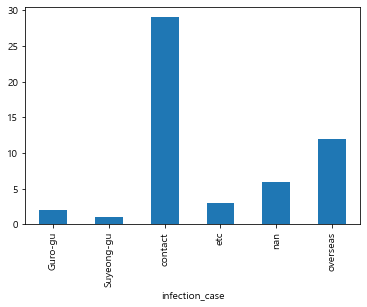

100s


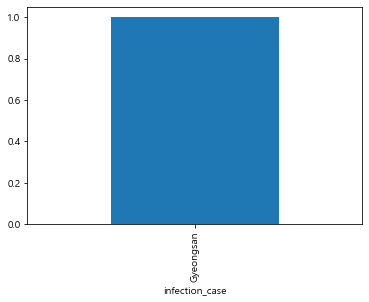

10s


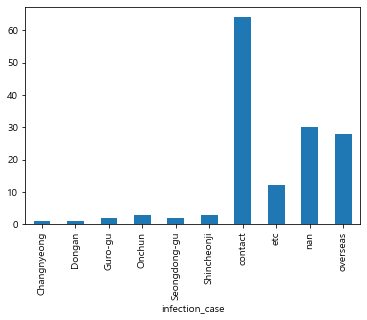

20s


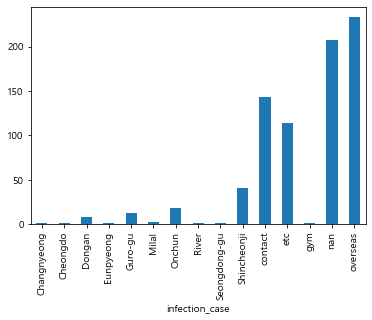

30s


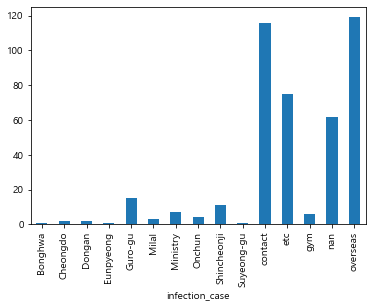

40s


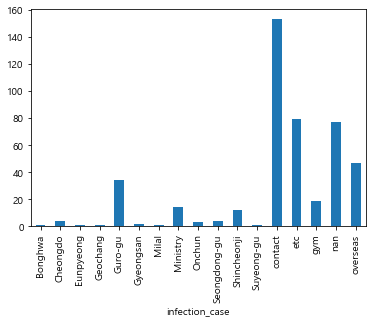

50s


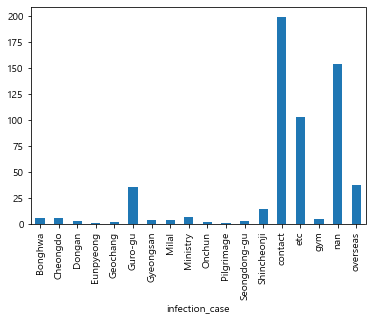

60s


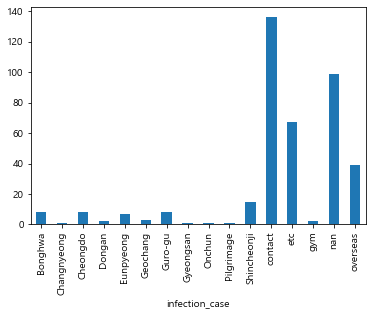

70s


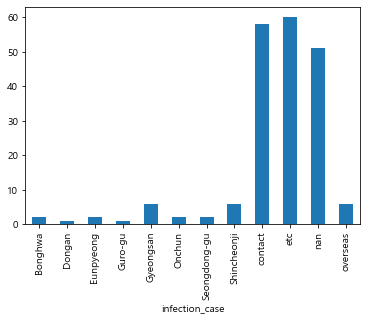

80s


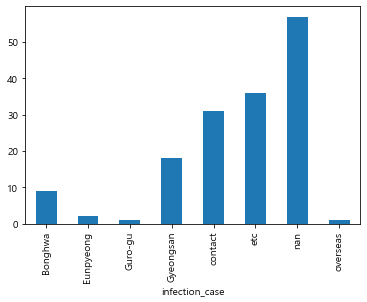

90s


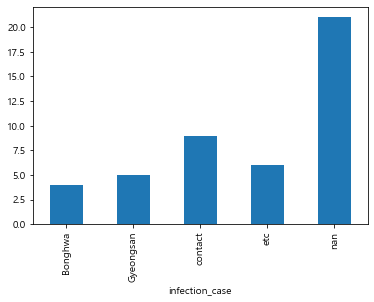

In [271]:
infectionCase = patientinfo.pivot_table(index='infection_case',columns='age',values='patient_id', aggfunc='count')
for col in infectionCase.columns:
    print(col)
    infectionCase[col].dropna().plot(kind='bar')
    plt.show()

In [273]:
fig = make_subplots(3,2, horizontal_spacing=0.03,
                   vertical_spacing=0.1)

for i, column in enumerate(['10s', '20s', '30s', '40s', '50s', '60s']):
    row, col = i//2 + 1, i%2 + 1
    ageInfectionCase = infectionCase[column].dropna()
    fig.add_trace(go.Bar(x=ageInfectionCase.index, y=ageInfectionCase.values,
                         name=column),row=row, col=col)
    
fig.update_layout(title="<b>연령별 감염 Case</b>",
                  height=1000, **layout_font)    
fig.show()

In [319]:
pinfoANDroute = pd.merge(route, patientinfo,on='patient_id').pivot_table(index='type', columns=['age'], values='patient_id', aggfunc='count')
pinfoANDroute.index = list(map(lambda x : x.split('_')[0], pinfoANDroute.index))
target = ["20s","30s","40s","50s"]

fig = make_subplots(2,2, horizontal_spacing=0.1,
                   vertical_spacing=0.1, subplot_titles=[f"{x}" for x in target])

for i, column in enumerate(target):
    row, col = i//2 + 1, i%2 + 1
    infectionRoute = pinfoANDroute[column].dropna()
    fig.add_trace(go.Bar(x=infectionRoute.values, y=infectionRoute.index,
                         name=column, orientation='h'),row=row, col=col)
    
fig.update_layout(title="<b>연령별 감염자 방문지역 Case</b>",
                  margin=dict(l=20, r=20, t=100, b=20),
                  height=1000, width=1000, **layout_font)    
fig.show()

In [322]:
pinfoANDroute = pd.merge(route, patientinfo,on='patient_id').pivot_table(index='type', columns=['age'], values='patient_id', aggfunc='count')
pinfoANDroute.index = list(map(lambda x : x.split('_')[0], pinfoANDroute.index))
target = ["20s", "50s"]

fig = make_subplots(1,2, horizontal_spacing=0.1,
                   vertical_spacing=0.1, subplot_titles=[f"{x}" for x in target])

for i, column in enumerate(target):
    row, col = i//2 + 1, i%2 + 1
    infectionRoute = pinfoANDroute[column]
    fig.add_trace(go.Bar(x=infectionRoute.values, y=infectionRoute.index,
                         name=column, orientation='h'),row=row, col=col)
    
fig.update_layout(title="<b>연령별 감염자 방문지역 Case</b>",
                  margin=dict(l=20, r=20, t=100, b=20),
                  height=600, width=1000, **layout_font)    
fig.show()

In [364]:
merged = pd.merge(route, patientinfo,on='patient_id')
pinfoANDroute = merged.pivot_table(index='type', columns=['age'], values='patient_id', aggfunc='count')
pinfoANDroute.index = list(map(lambda x : x.split('_')[0], pinfoANDroute.index))
target = ["20s", "50s"]
target_index = np.setdiff1d(pinfoANDroute.index, ['hospital','etc'])

fig = make_subplots(1,2, horizontal_spacing=0.2,
                   vertical_spacing=0.1, subplot_titles=[f"{x}" for x in target])

for i, column in enumerate(target):
    row, col = i//2 + 1, i%2 + 1
    infectionRoute = pinfoANDroute.loc[target_index,column]
    fig.add_trace(go.Bar(x=infectionRoute.values, y=infectionRoute.index,
                         name=column, orientation='h'),row=row, col=col)
    
fig.update_layout(title="<b>연령별 감염자 방문지역 Case</b>",
                  margin=dict(l=20, r=20, t=100, b=20),
                  height=600, width=1000, **layout_font)    

fig.update_xaxes(title_text="<b>방문 회수</b>", row=1, col=1)
fig.update_xaxes(title_text="<b>방문 회수</b>", row=1, col=2)
fig.update_yaxes(title_text="<b>Route</b>", row=1, col=1)
fig.update_yaxes(title_text="<b>Route</b>", row=1, col=2)

fig.show()

In [549]:
province_df=pd.DataFrame(p_info['province'].value_counts())
province_df=province_df.reset_index()
fig=px.pie(province_df, values='province', names='index', title='[전체 지역별 환자 수 및 비율(%)]', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

NameError: name 'p_info' is not defined

In [550]:
fig = make_subplots(1,2, 
                    horizontal_spacing=0.1,
                    vertical_spacing=0.1, 
                    specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=[f"{x}" for x in target])
target_index = np.setdiff1d(pinfoANDroute.index, ['hospital','etc','store',
                                                 'public','restaurant',
                                                 'church','pharmacy'])

for i, column in enumerate(target):
    row, col = i//2 + 1, i%2 + 1
    infectionRoute = pinfoANDroute.loc[target_index,column]
    fig.add_trace(go.Pie(labels=infectionRoute.index, 
                         values=infectionRoute.values, 
                         name=column),row=row, col=col)
    
fig.update_layout(title="<b>연령별 감염자 방문지역 Case</b>",
                  margin=dict(l=30, r=20, t=100, b=20),
                  height=600, width=1000, **layout_font)    
fig.show()

In [400]:
not_necessary = ['academy', 'bar', 'beauty', 'cafe','church',
                'gym','lodging','pc','school','store']

In [401]:
not_necessary = ['academy', 'bar', 'beauty', 'cafe','church',
                'gym','lodging','pc','school','store']

fig = make_subplots(1,2, 
                    horizontal_spacing=0.1,
                    vertical_spacing=0.1, 
                    specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=[f"{x}" for x in target])


for i, column in enumerate(target):
    row, col = i//2 + 1, i%2 + 1
    infectionRoute = pinfoANDroute.loc[not_necessary,column]
    fig.add_trace(go.Pie(labels=infectionRoute.index, 
                         values=infectionRoute.values, 
                         name=column),row=row, col=col)
    
fig.update_layout(title="<b>연령별 감염자 방문지역 Case</b>",
                  margin=dict(l=30, r=20, t=100, b=20),
                  height=600, width=1000, **layout_font)    
fig.show()

In [404]:
infectionRoute.values/sum(infectionRoute.values)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [410]:
target_index = not_necessary

fig = make_subplots(1,2, horizontal_spacing=0.2,
                   vertical_spacing=0.1, subplot_titles=[f"{x}" for x in target])

for i, column in enumerate(target):
    row, col = i//2 + 1, i%2 + 1
    infectionRoute = pinfoANDroute.loc[:,column].fillna(0)
    infectionRoute = infectionRoute / sum(infectionRoute)
    infectionRoute = infectionRoute[target_index]
    fig.add_trace(go.Bar(x=infectionRoute.values, y=infectionRoute.index,
                         name=column, orientation='h'),row=row, col=col)
    
fig.update_layout(title="<b>20대와 50대의 불필요 방문지역</b>",
                  margin=dict(l=20, r=20, t=100, b=20),
                  height=600, width=1000, **layout_font)    

fig.update_xaxes(title_text="<b>방문 비율</b>", row=1, col=1)
fig.update_xaxes(title_text="<b>방문 비율</b>", row=1, col=2)
fig.update_yaxes(title_text="<b>Route</b>", row=1, col=1)
fig.update_yaxes(title_text="<b>Route</b>", row=1, col=2)

fig.show()

In [442]:
route[:20]

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221
6,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.589590,127.009766
7,1000000002,5.0,2020-01-27,Seoul,Seongbuk-gu,restaurant,37.592057,127.018898
8,1000000002,5.0,2020-01-27,Seoul,Dongdaemun-gu,store,37.566262,127.065815
9,1000000002,5.0,2020-01-28,Seoul,Seongbuk-gu,etc,37.591669,127.018420


전체 비율에서 방문 지역의 비율을 확인해보았습니다. `not_necessary`는 필수적이지 않은 방문지역과 생활하는데 있어서 방문할 수밖에 없는 부분으로 나누었습니다. 위의 그래프에서는 불필요 방문 지역에 해당되는 부분을 확인해 보았습니다. 

전체적인 비율이 비슷합니다. 하지만, 20대의 경우 pc방이나 카페, bar 등의 방문지역이 상대적으로 높게 발생되는 것을 알 수 있습니다.

In [ ]:
r`

In [433]:
routeSTD = pinfoANDroute.fillna(0).std()

fig = go.Figure()
fig.add_trace(go.Bar(x=routeSTD.index, y=routeSTD.values,
                     name=column, marker=dict(color=DEFAULT_PLOTLY_COLORS)))

fig.update_layout(title="<b>방문지역 분산</b>",
              margin=dict(l=20, r=20, t=100, b=20),
              height=600, width=1000, **layout_font)    

fig.show()

방문 지역의 분산에서도 20대의 숫자가 매우 높은 것을 볼 수 있습니다. 즉, 20대가 유동인구는 적지만 움직이는 인원들이 불필요한 지역을 많이 방문하는 편입니다. 또한, 전반적으로 많은 지역에 방문하는 경우들도 많은 것을 볼 수 있었습니다. 

더 나아가 


부산 클럽 : https://www.cdc.go.kr/board/board.es?mid=a20501000000&bid=0015&list_no=367014&act=view


강남 클럽 : https://news.joins.com/article/23735119

놀이공원 :  https://www.nocutnews.co.kr/news/5322407

매일 스벅녀 : https://www.nocutnews.co.kr/news/5325329

등의 뉴스를 보았을 때, 20대들의 코로나 사회적 거리두기를 실천하지 않는 모습을 확인해 볼 수 있습니다.


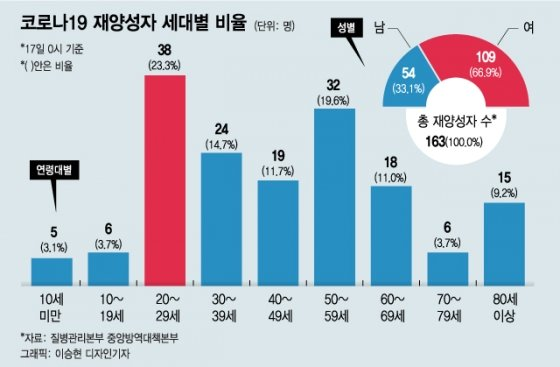
https://news.mt.co.kr/mtview.php?no=2020041714043594627
심지어 코로나 다시 걸리는 비율도 20대가 가장 많은 것을 확인할 수 있습니다.

서울대학교 보건대학원 유명순 교수팀이 지난달 25~27일간 한국리서치에 의뢰해 진행한 ‘코로나19국민 인식조사’를 분석해 10일 발표한 내용에서
20대의 코로나 바이러스에 대한 인식이 매우 낮은 것 또한 볼 수 있습니다. 

[출처: 중앙일보] “코로나 걸려도 심각하지 않겠지”…사회적 거리두기 참여율 낮은 20대

In [445]:
patientinfo

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,7000000009,9651.0,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas,NaN,NaN,14.0,NaN,2020-03-29,NaN,NaN,isolated
3322,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas,NaN,NaN,18.0,NaN,2020-04-03,NaN,NaN,isolated
3323,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact,NaN,7.000000e+09,5.0,NaN,2020-04-03,NaN,NaN,isolated
3324,7000000012,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas,NaN,NaN,9.0,NaN,2020-04-03,NaN,NaN,isolated


In [446]:
patientinfo.sort_values(by='contact_number', ascending=False)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
753,1200000031,31.0,female,1959.0,60s,Korea,Daegu,NaN,NaN,Shincheonji,NaN,NaN,1160.0,NaN,2020-02-18,NaN,NaN,isolated
624,1100000001,NaN,male,2001.0,10s,Korea,Busan,Dongnae-gu,NaN,Onchun,NaN,NaN,1091.0,NaN,2020-02-21,NaN,NaN,released
630,1100000007,NaN,male,1994.0,20s,China,Busan,NaN,NaN,Shincheonji,NaN,NaN,485.0,NaN,2020-02-22,NaN,NaN,released
816,1300000001,16.0,female,NaN,40s,Korea,Gwangju,NaN,NaN,overseas,NaN,NaN,450.0,2020-01-27,2020-02-03,2020-02-20,NaN,released
1067,2000000003,12.0,male,1971.0,40s,China,Gyeonggi-do,Bucheon-si,NaN,contact,2.0,NaN,422.0,NaN,2020-02-01,2020-02-18,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,6100000111,NaN,male,1999.0,20s,Korea,Gyeongsangnam-do,Sacheon-si,NaN,contact,NaN,6.100000e+09,NaN,2020-04-04,2020-04-06,NaN,NaN,isolated
3309,6100000112,NaN,male,1954.0,60s,Korea,Gyeongsangnam-do,Hapcheon-gun,NaN,contact,NaN,6.100000e+09,NaN,2020-04-03,2020-04-07,NaN,NaN,isolated
3310,6100000113,NaN,male,1990.0,30s,Korea,Gyeongsangnam-do,Geoje-si,NaN,overseas,NaN,NaN,NaN,2020-03-29,2020-04-08,NaN,NaN,isolated
3311,6100000114,NaN,female,2018.0,0s,Korea,Gyeongsangnam-do,Jinju-si,NaN,overseas,NaN,NaN,NaN,2020-04-01,2020-04-08,NaN,NaN,isolated
